In [1]:
from qiskit import QuantumRegister
import numpy as np
from gymnasium.spaces import Box
from rl_qoc import QuantumEnvironment, BenchmarkConfig
from rl_qoc.qibo import QiboEstimatorV2
from qiskit.circuit import QuantumCircuit, ParameterVector, Gate
from qiskit.circuit.library import CZGate
from rl_qoc import (
    QEnvConfig,
    QiskitRuntimeConfig as QiskitConfig,
    ExecutionConfig,
    ChannelConfig,
)
from qiskit import pulse


def param_circuit(
    qc: QuantumCircuit, params: ParameterVector, qreg: QuantumRegister, **kwargs
):
    cz_cal = Gate("cz_cal", 2, params.params)
    with pulse.build() as cz_sched:
        pulse.play(
            pulse.Gaussian(duration=160, amp=0.5, sigma=40), pulse.DriveChannel(0)
        )
        pulse.play(
            pulse.Gaussian(duration=160, amp=0.5, sigma=40), pulse.DriveChannel(1)
        )
        pulse.shift_phase(np.pi, pulse.DriveChannel(0))
        pulse.shift_phase(np.pi, pulse.DriveChannel(1))
    qc.append(cz_cal, qreg)
    qc.add_calibration(cz_cal, [0, 1], cz_sched)

    return qc


def get_backend():
    return None


qiskit_config = QiskitConfig(param_circuit, get_backend())
q_env_config = QEnvConfig(
    target={"gate": CZGate(), "physical_qubits": [0, 1]},
    backend_config=qiskit_config,
    action_space=Box(-np.pi, np.pi, (4,)),
    reward_config=ChannelConfig(),
    benchmark_config=BenchmarkConfig(0),
    execution_config=ExecutionConfig(batch_size=3, sampling_paulis=20, n_shots=10),
)

env = QuantumEnvironment(q_env_config)

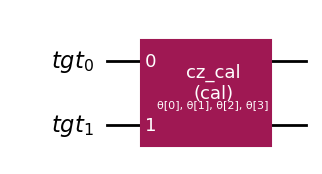

In [2]:
env.circuits[0].draw(output="mpl")

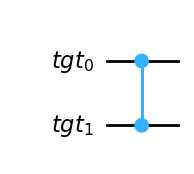

In [3]:
env.baseline_circuits[0].draw(output="mpl")

In [4]:
qibo_estimator = QiboEstimatorV2(backend=None)

In [21]:
env.estimator = qibo_estimator
env.step(np.random.uniform(-np.pi, np.pi, (env.batch_size, 4)))

Sending Estimator job...


KeyboardInterrupt: 